Load Dataset

In [1]:
%run "../src/utils/utils.py"

DIR_INPUT = "../data/transformed/"

BEGIN_DATE = "2018-07-25"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: total: 93.8 ms
Wall time: 83.4 ms
201295 transactions loaded, containing 1792 fraudulent transactions


In [2]:
# Compute the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_tx_stats(transactions_df, start_date_df="2018-04-01"):
    
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraudulent_transactions_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of compromised cards per day
    nb_compromised_cards_per_day=transactions_df[transactions_df['TX_FRAUD']==1].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    tx_stats=pd.DataFrame({"nb_tx_per_day":nb_tx_per_day,
                           "nb_fraudulent_transactions_per_day":nb_fraudulent_transactions_per_day,
                           "nb_compromised_cards_per_day":nb_compromised_cards_per_day})

    tx_stats=tx_stats.reset_index()
    
    start_date = datetime.datetime.strptime(start_date_df, "%Y-%m-%d")
    tx_date=start_date+tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)
    
    tx_stats['tx_date']=tx_date
    
    return tx_stats

tx_stats=get_tx_stats(transactions_df, start_date_df="2018-04-01")

In [3]:
%%capture

import matplotlib.pyplot as plt
# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_template_tx_stats(ax ,fs,
                          start_date_training,
                          title='',
                          delta_train=7,
                          delta_delay=7,
                          delta_test=7,
                          ylim=300):
    
    ax.set_title(title, fontsize=fs*1.5)
    ax.set_ylim([0, ylim])
    
    ax.set_xlabel('Date', fontsize=fs)
    ax.set_ylabel('Number', fontsize=fs)
    
    plt.yticks(fontsize=fs*0.7) 
    plt.xticks(fontsize=fs*0.7)    

    ax.axvline(start_date_training+datetime.timedelta(days=delta_train), 0,ylim, color="black")
    ax.axvline(start_date_test, 0, ylim, color="black")
    
    ax.text(start_date_training+datetime.timedelta(days=2), ylim-20,'Training period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+2), ylim-20,'Delay period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+delta_delay+2), ylim-20,'Test period', fontsize=fs)


cmap = plt.get_cmap('jet')
colors={'nb_tx_per_day':cmap(0), 
        'nb_fraudulent_transactions_per_day':cmap(200), 
        'nb_compromised_cards_per_day':cmap(250)}

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Total transactions, and number of fraudulent transactions \n and number of compromised cards per day',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b', color=colors['nb_tx_per_day'], label = '# transactions per day (/50)')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day')
ax.plot(tx_stats['tx_date'], tx_stats['nb_compromised_cards_per_day'], 'b', color=colors['nb_compromised_cards_per_day'], label = '# compromised cards per day')

ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)

plt.show()

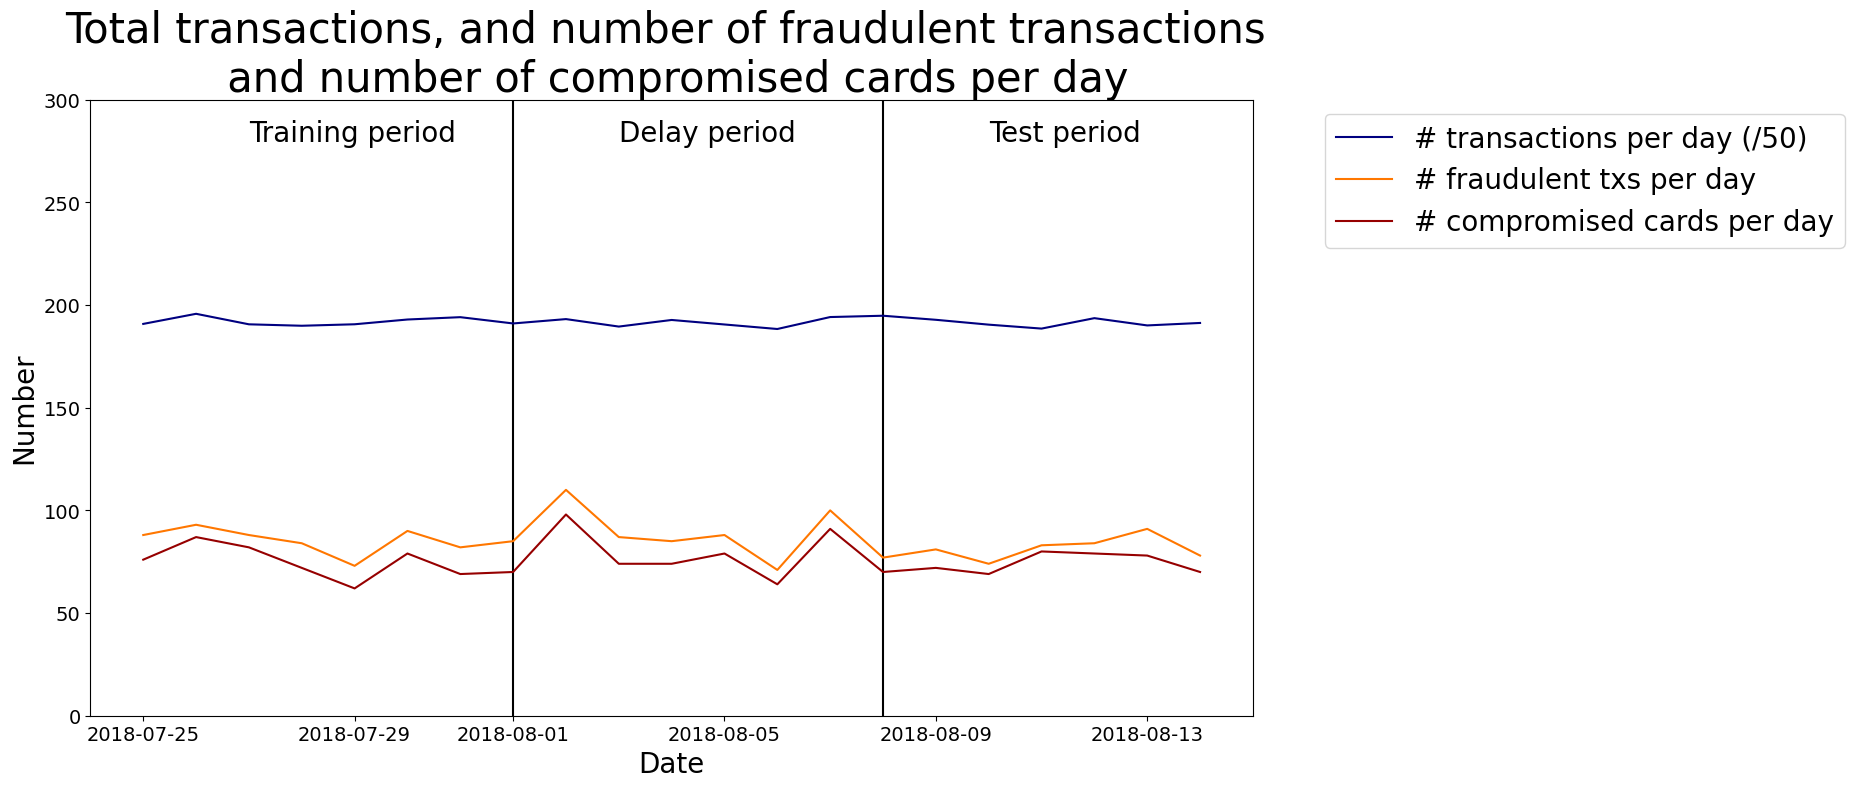

In [4]:
fraud_and_transactions_stats_fig

In [5]:
current_dir = os.getcwd()
root_dir = os.path.join(current_dir, '..')
sys.path.append(root_dir)

from src.utils import utils

In [6]:
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")

delta_train = delta_delay = delta_test = 7

(train_df, test_df) = get_train_test_set(transactions_df, start_date_training,
                                       delta_train=7, delta_delay=7, delta_test=7)

target = "TX_FRAUD"

features =['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

In [7]:
num_tx_train = train_df.shape[0]
num_fraud_train = train_df[train_df['TX_FRAUD']==1].shape[0]
num_tx_test = test_df.shape[0]
num_fraud_test = test_df[test_df['TX_FRAUD']==1].shape[0]

print("Number of transactions in training set: ", num_tx_train)
print("Number of fraudulent transactions in training set: ", num_fraud_train)
print("Proportion of fraudulent transactions in training set: ", num_fraud_train/num_tx_train)
print("Number of transactions in test set: ", num_tx_test)
print("Number of fraudulent transactions in test set: ", num_fraud_test)
print("Proportion of fraudulent transactions in test set: ", num_fraud_test/num_tx_test)


Number of transactions in training set:  67240
Number of fraudulent transactions in training set:  598
Proportion of fraudulent transactions in training set:  0.008893515764425937
Number of transactions in test set:  58264
Number of fraudulent transactions in test set:  385
Proportion of fraudulent transactions in test set:  0.00660785390635727


In [8]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

model_and_predictions_dictionary = fit_model_and_predict(classifier, train_df, test_df, 
                                                                 features, target,
                                                                 scale=False)

In [9]:
test_df['TX_FRAUD_PREDICTED']=model_and_predictions_dictionary['predictions_test']
test_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD_PREDICTED
134215,1236698,2018-08-08 00:01:14,2765,2747,42.32,11145674,129,0,0,0,...,67.468529,120.0,64.611750,2.0,0.0,9.0,0.0,31.0,0.000000,0.003536
134216,1236699,2018-08-08 00:02:33,714,2073,108.19,11145753,129,0,0,0,...,79.955455,124.0,85.365645,2.0,0.0,10.0,0.0,23.0,0.000000,0.003536
134218,1236701,2018-08-08 00:08:40,4982,1258,26.13,11146120,129,0,0,0,...,56.269167,61.0,49.095902,1.0,0.0,10.0,0.0,26.0,0.076923,0.003536
134219,1236702,2018-08-08 00:08:41,704,8501,65.81,11146121,129,0,0,0,...,62.643333,11.0,63.287273,1.0,0.0,6.0,0.0,23.0,0.000000,0.003536
134220,1236703,2018-08-08 00:10:34,3085,4208,55.22,11146234,129,0,0,0,...,71.993846,72.0,59.899306,1.0,0.0,5.0,0.0,21.0,0.523810,0.003536


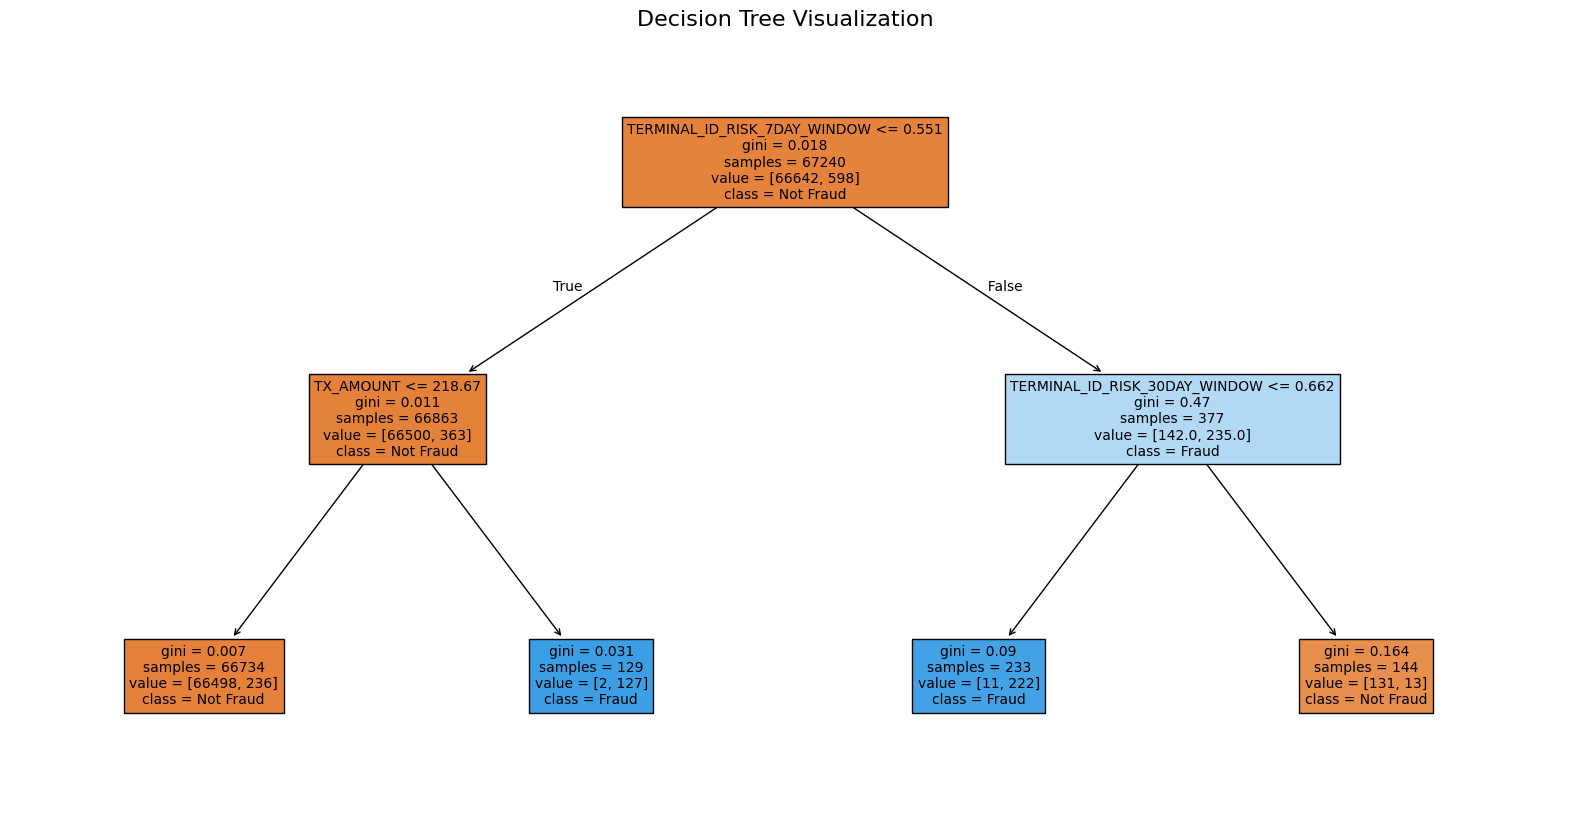

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(classifier, out_file=None, 
                          feature_names=features,  
                          class_names=['Not Fraud', 'Fraud'],  
                          filled=True)  
graph = graphviz.Source(dot_data)  
graph.render("decision_tree")  

In [11]:
target

'TX_FRAUD'